<a href="https://colab.research.google.com/github/hdighidy/IBM-Machine-Learning-Professional-Certificate/blob/main/Differentiated_Thyroid_Cancer_Recurrence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'differentiated-thyroid-cancer-recurrence:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4324904%2F7431940%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240205%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240205T183824Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D641f17d89a027eb2f422efa749e043f28589ee674b136d669da488d8449a06e1f991d4d07add3de071bc9d43fff12fe6adbfc0776a281e41afa43880450012ee43f6afdeffa937c3a9832b78a9020f0e510406261c44933e504cbb83c17f4f01fa1d7951f4fb913cc7ce444c56cad67338fc6829dbb75ace87de9864752bb51f2a1ee2f09479a6bb04cd4445d1f78fa382431d20af9a9d6aa7ab13c0851f62e26e0523283647ac28173747e1d8edab2b10afb2028d0a319cf8cdf6a256e7898353eb21841d6c7e7fbec6869ef4824fdfa04cdac20efe09b8dd767809d068ddc38fbb120cef55f63fa8c5b22d79655f6259649472dce30b6c9548117a5afc856d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3100 bytes downloaded
Downloaded and uncompressed: differentiated-thyroid-cancer-recurrence
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/differentiated-thyroid-cancer-recurrence/Thyroid_Diff.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [4]:
df = pd.read_csv("/kaggle/input/differentiated-thyroid-cancer-recurrence/Thyroid_Diff.csv")

In [5]:
df.head(3)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

In [7]:
df.isnull().sum()

Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64

<Axes: >

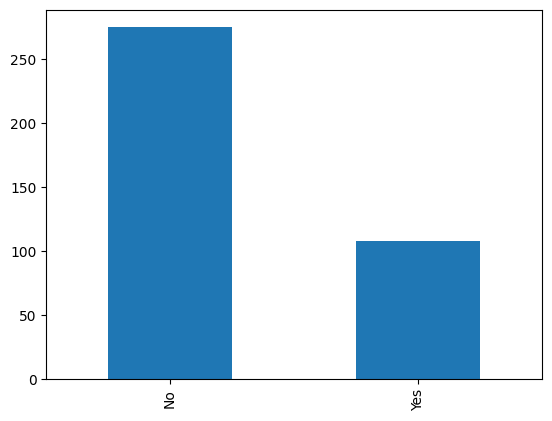

In [8]:
df.Recurred.value_counts().plot(kind='bar')

In [9]:
df.nunique()

Age                     65
Gender                   2
Smoking                  2
Hx Smoking               2
Hx Radiothreapy          2
Thyroid Function         5
Physical Examination     5
Adenopathy               6
Pathology                4
Focality                 2
Risk                     3
T                        7
N                        3
M                        2
Stage                    5
Response                 4
Recurred                 2
dtype: int64

In [10]:
df.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

<Axes: >

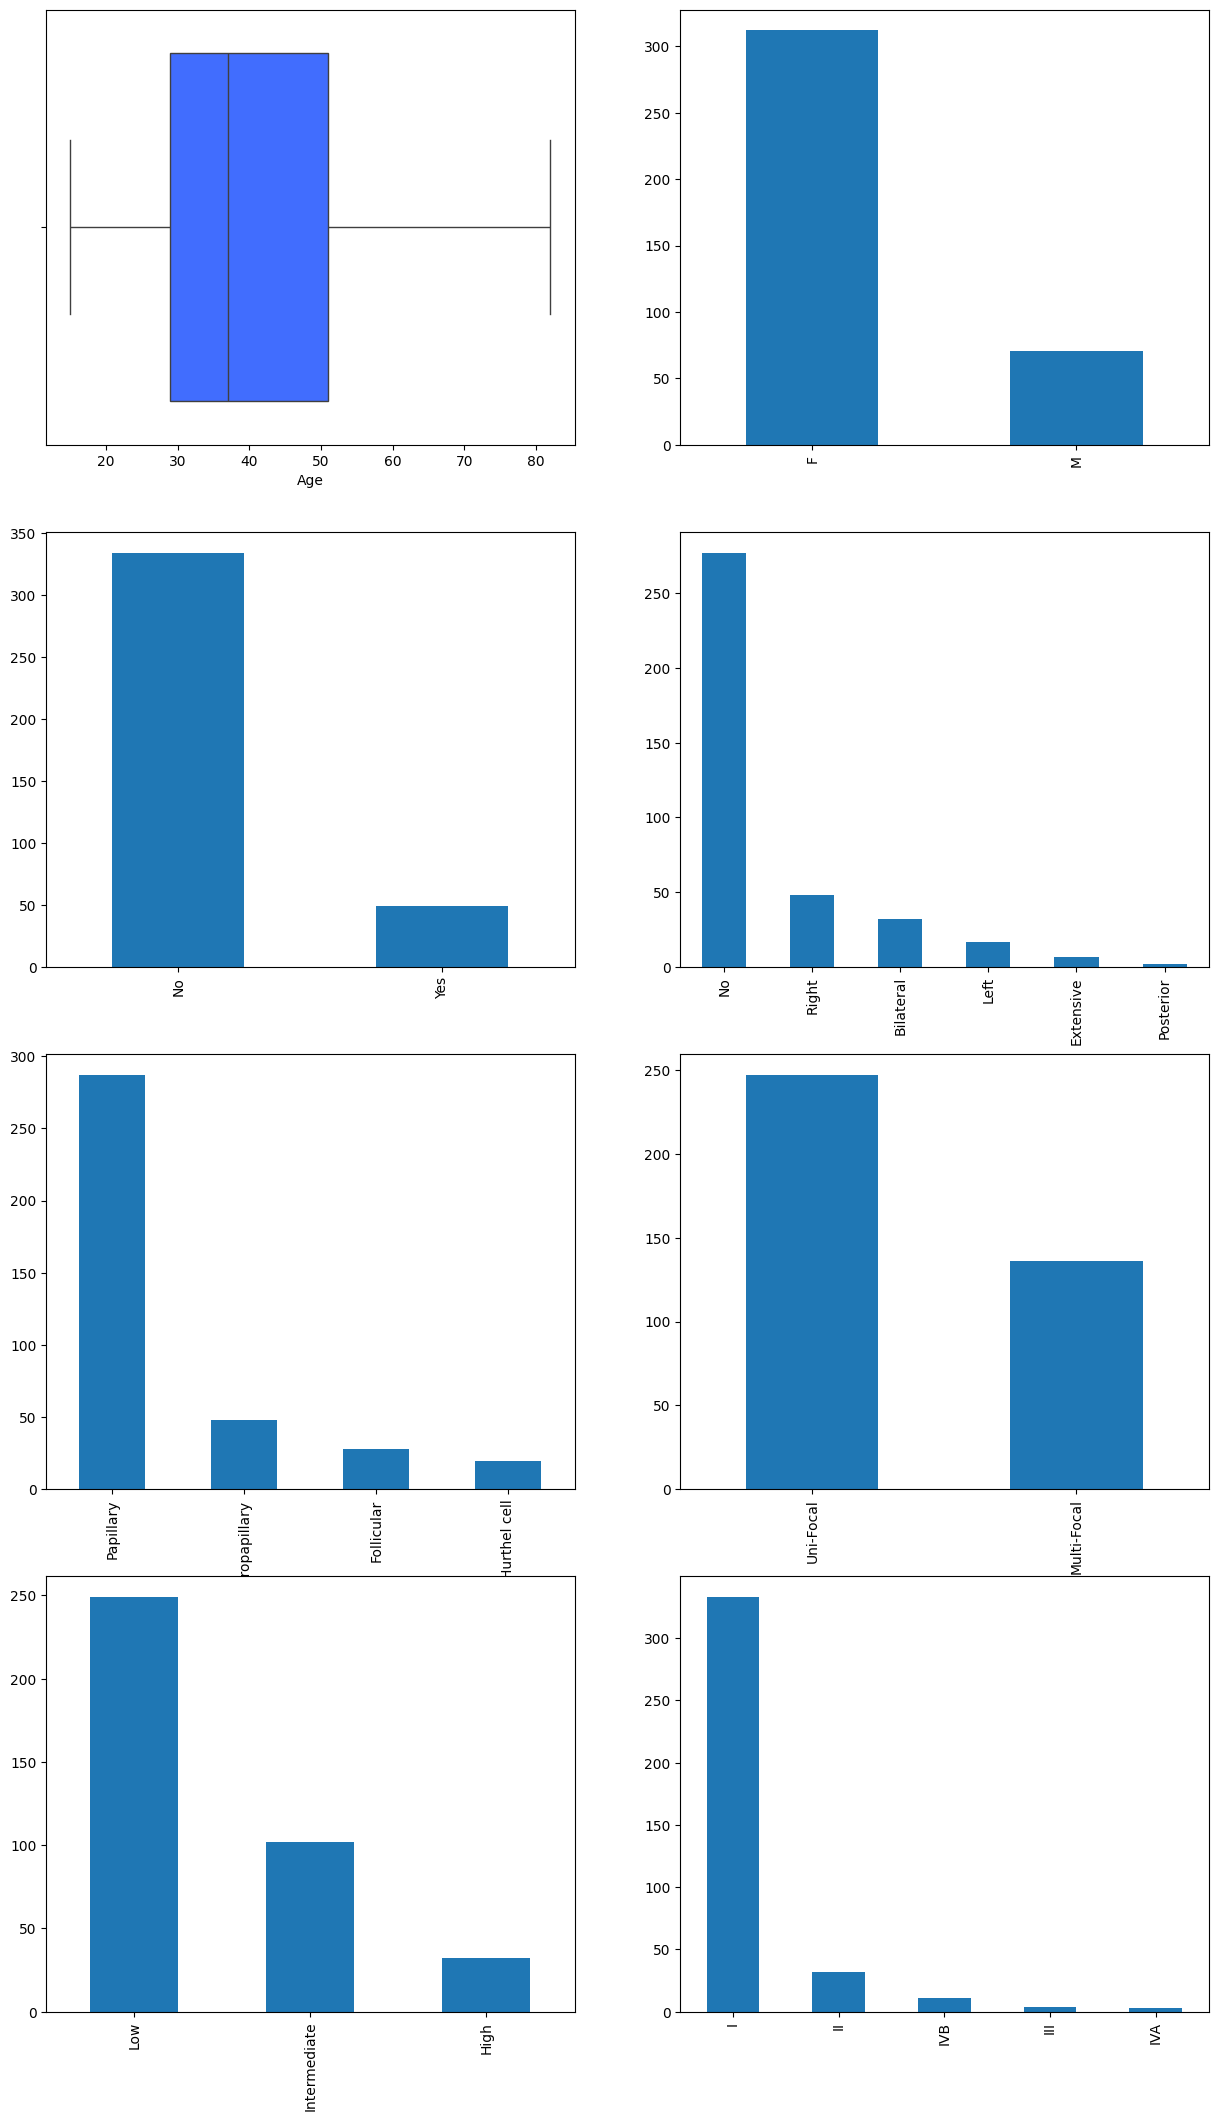

In [11]:
plt.figure(figsize=(15,26))
plt.subplot(4,2,1)
sns.boxplot(df.Age,orient='h', boxprops=dict(facecolor='#416DFE'))
plt.subplot(4,2,2)
df.Gender.value_counts().plot(kind='bar')
plt.subplot(4,2,3)
df.Smoking.value_counts().plot(kind='bar')
plt.subplot(4,2,4)
df.Adenopathy.value_counts().plot(kind='bar')
plt.subplot(4,2,5)
df.Pathology.value_counts().plot(kind='bar')
plt.subplot(4,2,6)
df.Focality.value_counts().plot(kind='bar')
plt.subplot(4,2,7)
df.Risk.value_counts().plot(kind='bar')
plt.subplot(4,2,8)
df.Stage.value_counts().plot(kind='bar')

In [12]:
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
Age,65
Gender,2
Smoking,2
Hx Smoking,2
Hx Radiothreapy,2
Thyroid Function,5
Physical Examination,5
Adenopathy,6
Pathology,4


In [13]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['Gender',
 'Smoking',
 'Hx Smoking',
 'Hx Radiothreapy',
 'Focality',
 'M',
 'Recurred']

In [14]:
[[i, list(df[i].unique())] for i in binary_variables]

[['Gender', ['F', 'M']],
 ['Smoking', ['No', 'Yes']],
 ['Hx Smoking', ['No', 'Yes']],
 ['Hx Radiothreapy', ['No', 'Yes']],
 ['Focality', ['Uni-Focal', 'Multi-Focal']],
 ['M', ['M0', 'M1']],
 ['Recurred', ['No', 'Yes']]]

In [15]:
categorical_variables = list(df_uniques[(12 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['Thyroid Function',
 'Physical Examination',
 'Adenopathy',
 'Pathology',
 'Risk',
 'T',
 'N',
 'Stage',
 'Response']

In [16]:
[[i, list(df[i].unique())] for i in categorical_variables]

[['Thyroid Function',
  ['Euthyroid',
   'Clinical Hyperthyroidism',
   'Clinical Hypothyroidism',
   'Subclinical Hyperthyroidism',
   'Subclinical Hypothyroidism']],
 ['Physical Examination',
  ['Single nodular goiter-left',
   'Multinodular goiter',
   'Single nodular goiter-right',
   'Normal',
   'Diffuse goiter']],
 ['Adenopathy',
  ['No', 'Right', 'Extensive', 'Left', 'Bilateral', 'Posterior']],
 ['Pathology', ['Micropapillary', 'Papillary', 'Follicular', 'Hurthel cell']],
 ['Risk', ['Low', 'Intermediate', 'High']],
 ['T', ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b']],
 ['N', ['N0', 'N1b', 'N1a']],
 ['Stage', ['I', 'II', 'IVB', 'III', 'IVA']],
 ['Response',
  ['Indeterminate',
   'Excellent',
   'Structural Incomplete',
   'Biochemical Incomplete']]]

In [17]:
label_encoder = LabelEncoder()

for column in df.select_dtypes(include='object').columns:
    df[column] = label_encoder.fit_transform(df[column])

In [18]:
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2,0
1,34,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1,0
2,30,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
3,62,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
4,62,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1,0


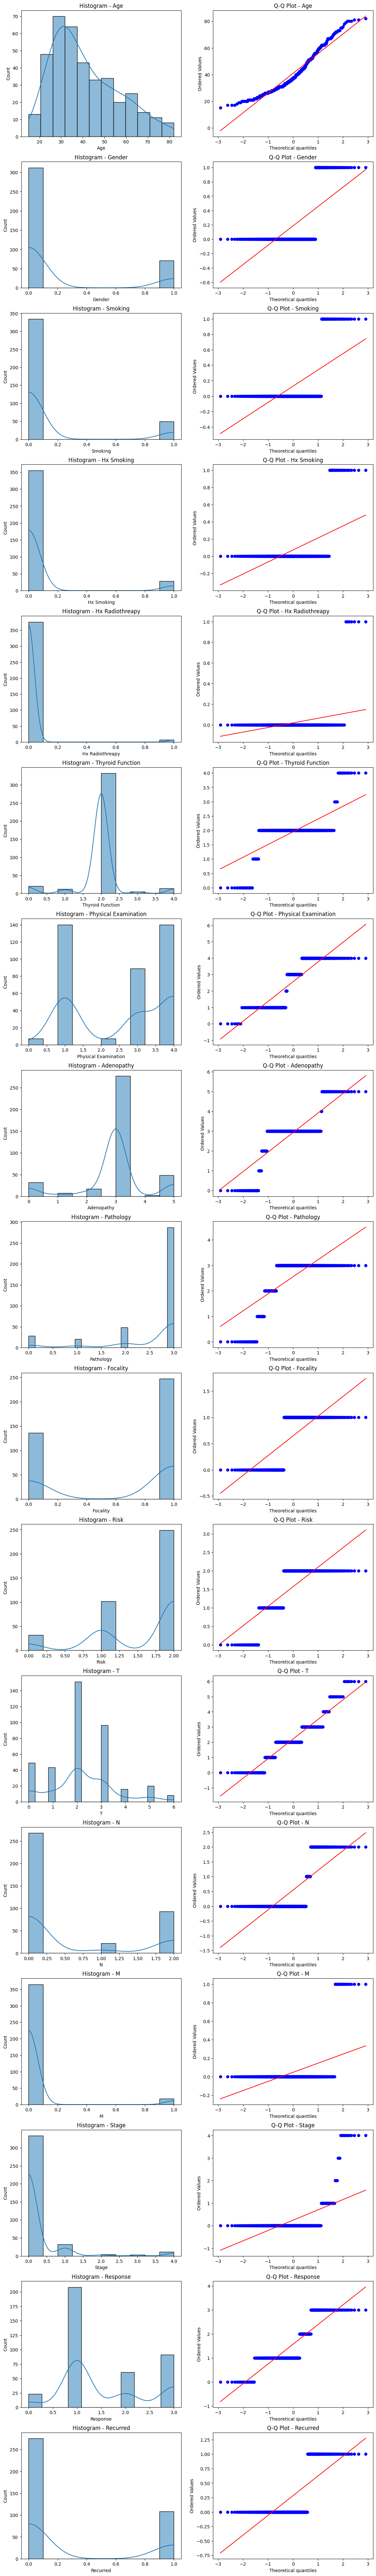

In [19]:
from scipy.stats import norm, probplot

features = df.columns

# Set up subplots
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(14, 6 * len(features)))

for i, feature in enumerate(features):
    # Plot histogram
    sns.histplot(df[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram - {feature}')

    # Probability plot (Q-Q plot)
    probplot(df[feature], plot=axes[i, 1], dist='norm', fit=True)
    axes[i, 1].set_title(f'Q-Q Plot - {feature}')

plt.show()

In [20]:
# Set up X and y variables
y, X = df['Recurred'], df.drop(columns='Recurred')

In [21]:
y

0      0
1      0
2      0
3      0
4      0
      ..
378    1
379    1
380    1
381    1
382    1
Name: Recurred, Length: 383, dtype: int64

In [22]:
sm = SMOTE(random_state=46)
X_res, y_res = sm.fit_resample(X, y)

In [23]:
y_res.value_counts()

0    275
1    275
Name: Recurred, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.head(3)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response
482,62,0,0,0,0,1,1,3,3,0,1,2,0,0,0,0
158,33,0,0,0,0,2,4,3,3,1,2,2,0,0,0,1
15,42,0,0,0,0,2,4,3,2,1,2,0,0,0,0,2


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [26]:
X_train.shape

(440, 16)

In [27]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        59
           1       0.91      0.96      0.93        51

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110

Accuracy score:  0.94
F1 Score:  0.93


Text(0.5, 102.72222222222219, 'Ground Truth')

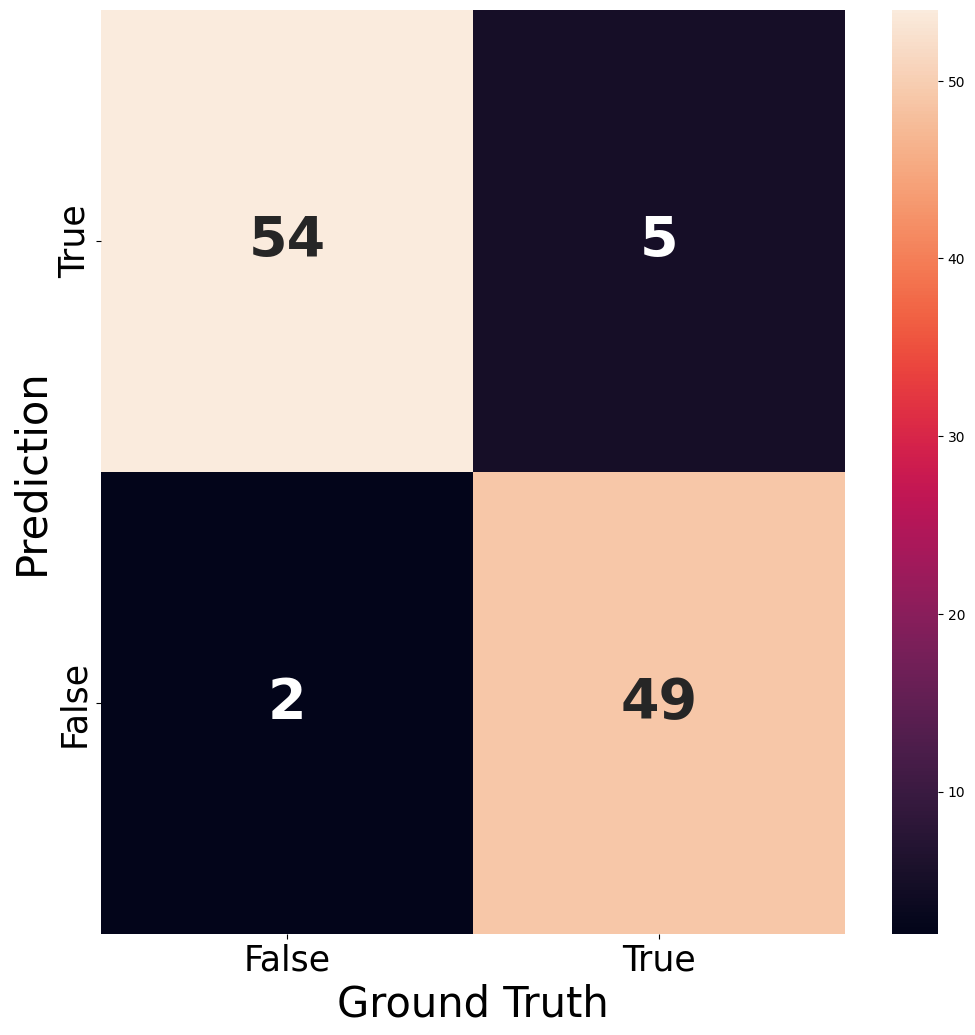

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette())
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

In [29]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        59
           1       0.96      0.96      0.96        51

    accuracy                           0.96       110
   macro avg       0.96      0.96      0.96       110
weighted avg       0.96      0.96      0.96       110

Accuracy score:  0.96
F1 Score:  0.96


Text(0.5, 102.72222222222219, 'Ground Truth')

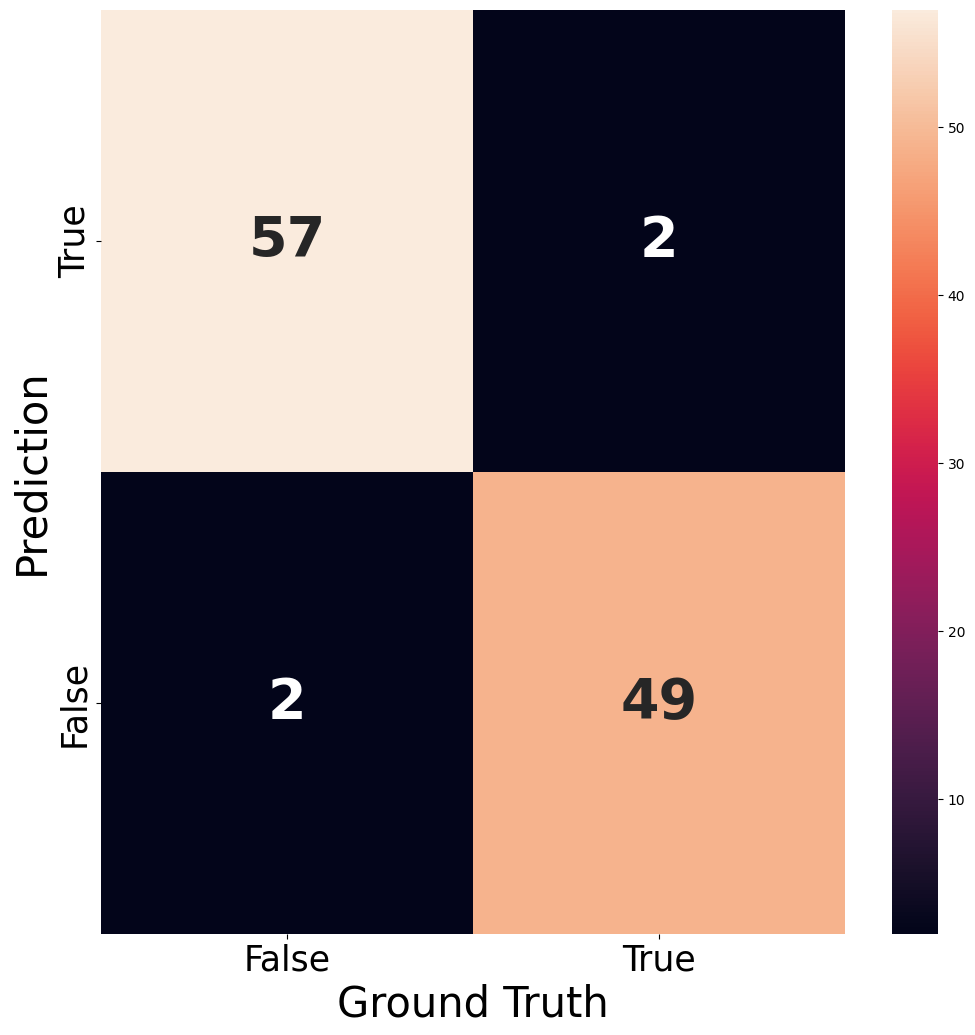

In [30]:
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

In [31]:
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):

    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))

f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1920x1440 with 0 Axes>

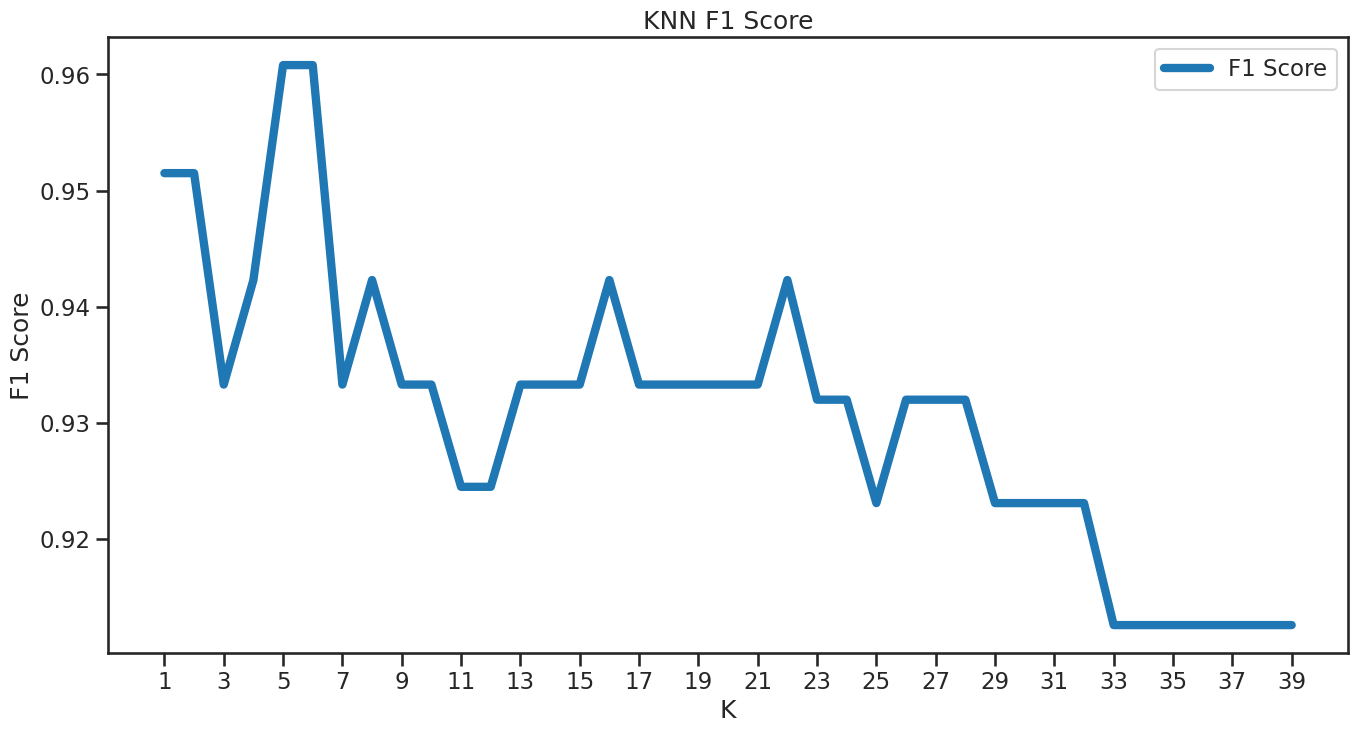

In [32]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(16, 8), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 1920x1440 with 0 Axes>

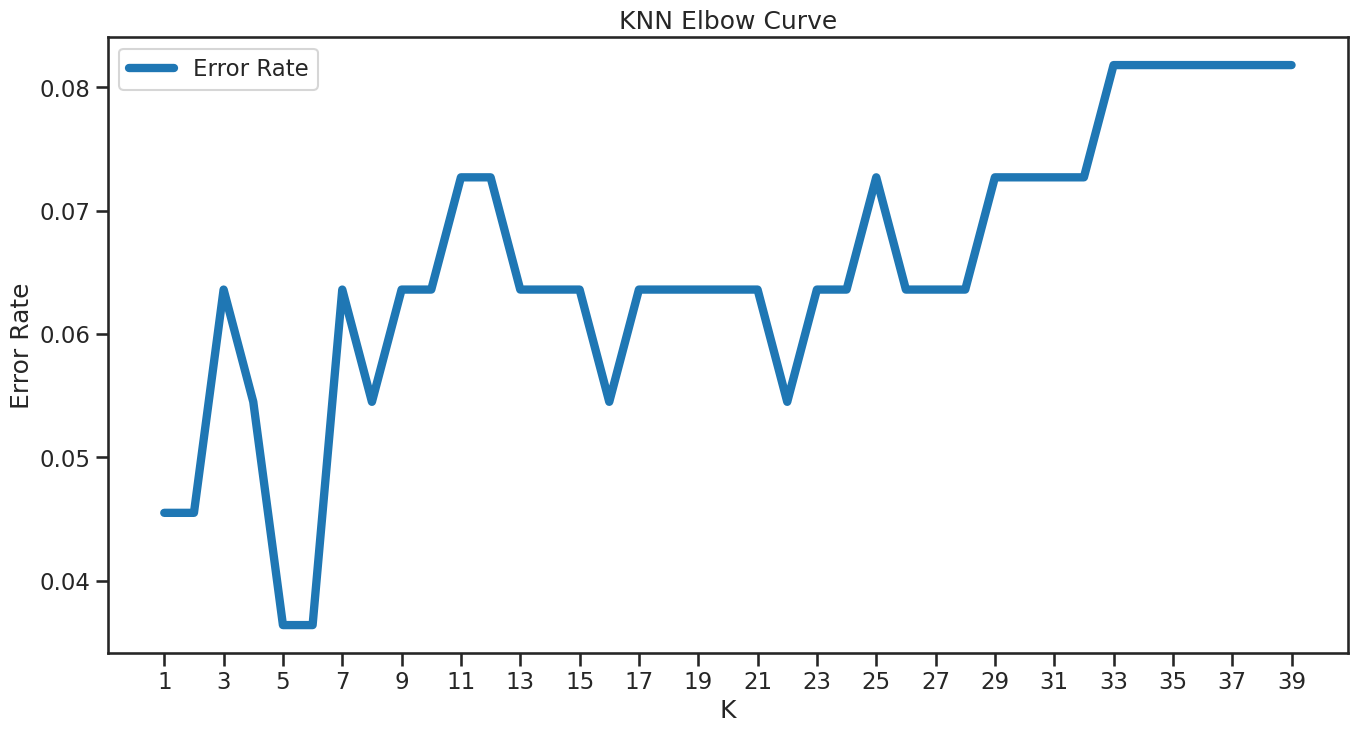

In [33]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(16, 8), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

In [34]:
f1_results.head(10)

,K,F1 Score
0,1,0.9515
1,2,0.9515
2,3,0.9333
3,4,0.9423
4,5,0.9608
5,6,0.9608
6,7,0.9333
7,8,0.9423
8,9,0.9333
9,10,0.9333


In [35]:
def training(model, name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = accuracy_score(y_test, pred)
    report = classification_report(y_test, pred)
    cm = confusion_matrix(y_test, pred)
    print(report)
    sns.heatmap(cm, annot=True)
    plt.title("{}: {}%".format(name, round(score*100, 2)))
    plt.show()

In [36]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

rfc = RandomForestClassifier()
abc = AdaBoostClassifier(learning_rate=0.9)
xgb = XGBClassifier(learning_rate=0.9)
gbc = GradientBoostingClassifier(learning_rate=0.9)

models = [rfc, abc, xgb, gbc]
names = ["Random Forest", "Ada Boost", "XGBoost", "Gradient Boosting"]

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        59
           1       0.94      0.98      0.96        51

    accuracy                           0.96       110
   macro avg       0.96      0.96      0.96       110
weighted avg       0.96      0.96      0.96       110



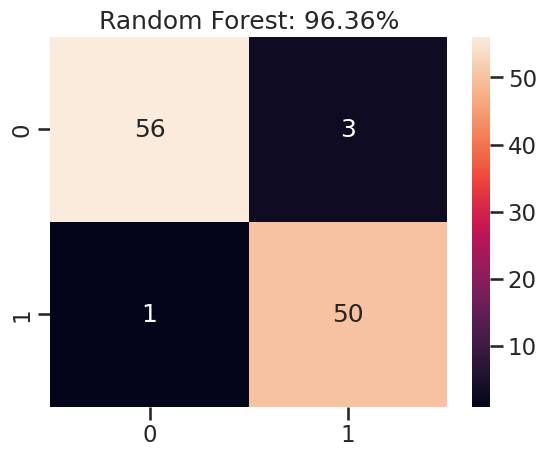

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        59
           1       0.91      0.98      0.94        51

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110



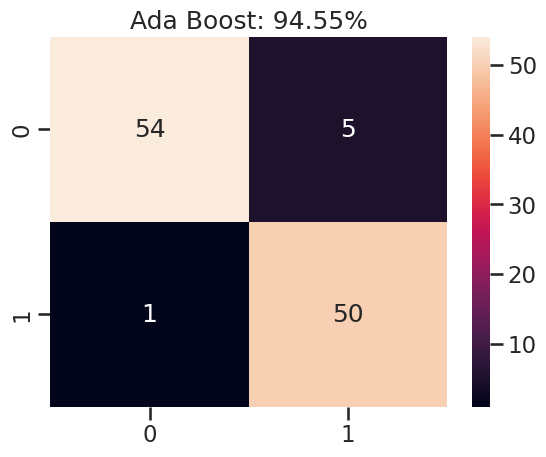

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        59
           1       0.93      1.00      0.96        51

    accuracy                           0.96       110
   macro avg       0.96      0.97      0.96       110
weighted avg       0.97      0.96      0.96       110



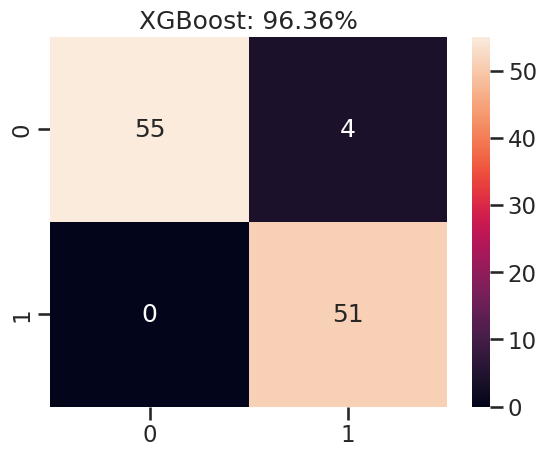

              precision    recall  f1-score   support

           0       0.98      0.93      0.96        59
           1       0.93      0.98      0.95        51

    accuracy                           0.95       110
   macro avg       0.95      0.96      0.95       110
weighted avg       0.96      0.95      0.95       110



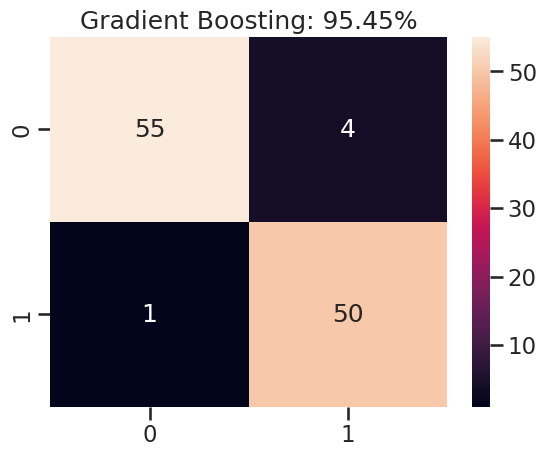

In [37]:
for i, j in zip(models, names):
    training(i, j)